In [1]:
!pip install transformers

   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
    --------------------------------------- 0.3/12.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.6/12.0 MB 7.0 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/12.0 MB 4.4 MB/s eta 0:00:03
   --------- ------------------------------ 2.9/12.0 MB 3.8 MB/s eta 0:00:03
   ---------- ----------------------------- 3.1/12.0 MB 3.6 MB/s eta 0:00:03
   ------------ --------------------------- 3.7/12.0 MB 3.2 MB/s eta 0:00:03
   ------------- -------------------------- 4.2/12.0 MB 3.0 MB/s eta 0:00:03
   -------------- ------------------------- 4.5/12.0 MB 2.9 MB/s eta 0:00:03
   ---------------- ----------------------- 5.0/12.0 MB 2.8 MB/s eta 0:00:03
   ------------------ --------------------- 5.5/12.0 MB 2.7 MB/s eta 0:00:03
   -------------------- ------------------- 6.0/12.0 MB 2.7 MB/s eta 0:00:03
   -------------------- ------------------- 6.3/12.0 MB 2.6 MB/s eta 0:00:03
   ----------

In [3]:
import torch
from transformers import CLIPProcessor, CLIPModel

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

# 2. Load CLIP Model with SafeTensors
model_id = "openai/clip-vit-base-patch32"
print(f"⏳ Loading VLM: {model_id}...")

# --- THE FIX IS HERE (use_safetensors=True) ---
model = CLIPModel.from_pretrained(model_id, use_safetensors=True).to(device)
processor = CLIPProcessor.from_pretrained(model_id)

print("✅ VLM Loaded Successfully!")

🚀 Device: cuda
⏳ Loading VLM: openai/clip-vit-base-patch32...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ VLM Loaded Successfully!


In [5]:
import pandas as pd
import os

# Define paths (Adjust if your folder structure is different)
train_path = os.path.join("data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv")
test_path = os.path.join("data/CrisisMMD/crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv")

# --- 1. Load Training Data ---
train_df = pd.read_csv(train_path, sep='\t')

# Create numerical labels for Training
train_code = []
for i in range(train_df.shape[0]):
    if train_df.iloc[i]['label_image'] == 'informative':
        train_code.append(1)
    elif train_df.iloc[i]['label_image'] == 'not_informative':
        train_code.append(0)
    else:
        train_code.append(None) # Handle errors
        
train_df['label'] = train_code
# Remove rows with bad labels if any
train_df = train_df.dropna(subset=['label'])
train_df['label'] = train_df['label'].astype(int)

# --- 2. Load Test Data ---
test_df = pd.read_csv(test_path, sep='\t')

# Create numerical labels for Testing
test_code = []
for i in range(test_df.shape[0]):
    if test_df.iloc[i]['label_image'] == 'informative':
        test_code.append(1)
    elif test_df.iloc[i]['label_image'] == 'not_informative':
        test_code.append(0)
    else:
        test_code.append(None)

test_df['label'] = test_code
test_df = test_df.dropna(subset=['label'])
test_df['label'] = test_df['label'].astype(int)

print(f"✅ Data Reloaded!")
print(f"   Train Size: {len(train_df)}")
print(f"   Test Size:  {len(test_df)}")

# --- NOW you can run your extraction code ---
print("\n--- Processing Training Data ---")
X_train, y_train = extract_features(train_df)

print("\n--- Processing Test Data ---")
X_test, y_test = extract_features(test_df)

✅ Data Reloaded!
   Train Size: 13608
   Test Size:  2237

--- Processing Training Data ---
🚀 Extracting features for 13608 samples...


 52%|█████▏    | 221/426 [07:28<06:36,  1.93s/it]d:\Anaconda\envs\tweet_project\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 426/426 [12:26<00:00,  1.75s/it]



--- Processing Test Data ---
🚀 Extracting features for 2237 samples...


100%|██████████| 70/70 [01:31<00:00,  1.31s/it]


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Initialize Classifier
# We use Logistic Regression because CLIP features are linearly separable
clf = LogisticRegression(max_iter=1000, C=1.0)

# 2. Train (This takes seconds)
print("🚀 Training Classifier...")
clf.fit(X_train, y_train)

# 3. Predict
print("🚀 Running Predictions...")
y_pred = clf.predict(X_test)

# 4. Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"\n🏆 VLM Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

🚀 Training Classifier...
🚀 Running Predictions...

🏆 VLM Accuracy: 0.8842

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1086
           1       0.88      0.90      0.89      1151

    accuracy                           0.88      2237
   macro avg       0.88      0.88      0.88      2237
weighted avg       0.88      0.88      0.88      2237



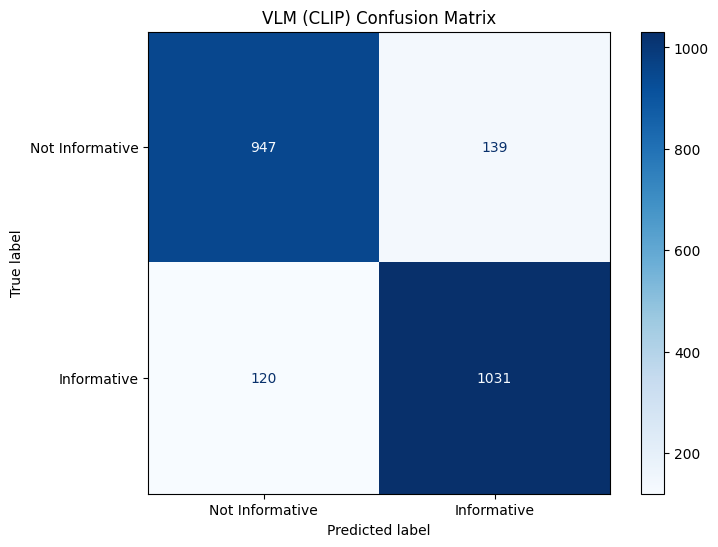

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

# 2. Create the Plot
fig, ax = plt.subplots(figsize=(8, 6))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Informative", "Informative"])
disp.plot(cmap='Blues', ax=ax)

plt.title("VLM (CLIP) Confusion Matrix")
plt.grid(False) # Turn off grid lines for cleaner look
plt.show()

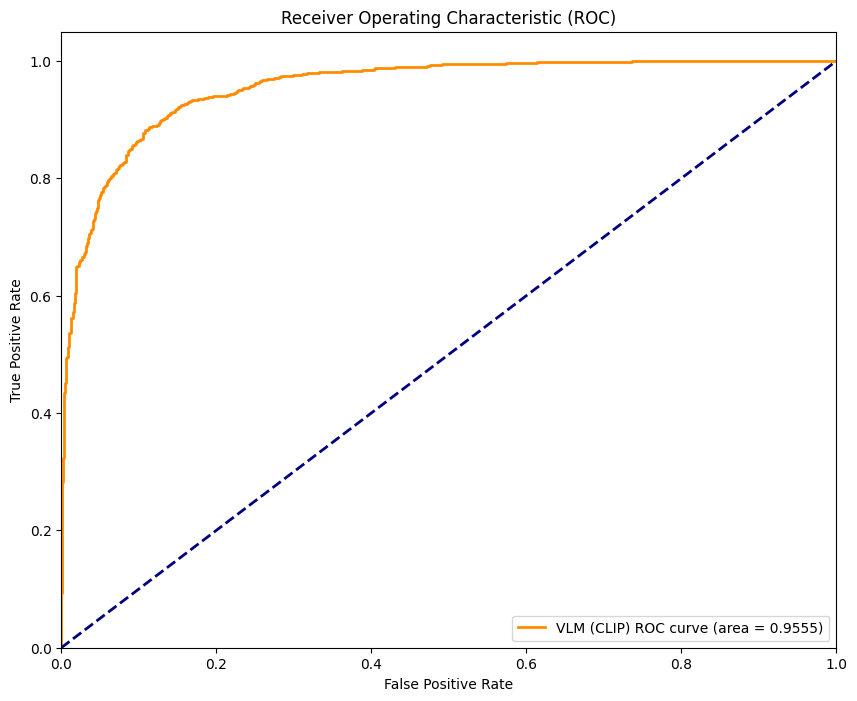

In [8]:
from sklearn.metrics import roc_curve, auc

# 1. Get Probabilities (Confidence scores) instead of just labels
y_prob = clf.predict_proba(X_test)[:, 1] # Get probability for Class 1 (Informative)

# 2. Calculate ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 3. Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'VLM (CLIP) ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal random guess line

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

🚀 Generating Learning Curve... (This tests the model on different data sizes)


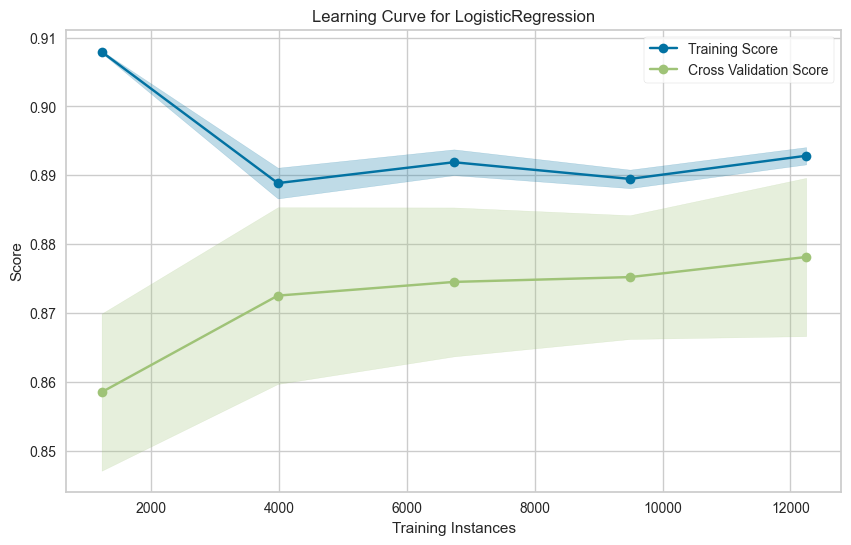

<Axes: title={'center': 'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [9]:
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve
from sklearn.linear_model import LogisticRegression

# 1. Setup the figure
fig, ax = plt.subplots(figsize=(10, 6))

# 2. Re-initialize the classifier (Yellowbrick needs a fresh instance)
#    We use the same settings as your trained VLM classifier
clf_for_plotting = LogisticRegression(max_iter=1000, C=1.0)

# 3. Initialize the Learning Curve Visualizer
visualizer = LearningCurve(
    clf_for_plotting, 
    cv=10,             # 10-fold cross-validation
    scoring='f1',      # Metric to track (F1 Score)
    n_jobs=-1,         # Use all CPU cores for speed
    ax=ax
)

# 4. Fit using your CLIP Training Features (X_train, y_train)
#    Note: We use the TRAINING set here. The curve will handle the splitting.
print("🚀 Generating Learning Curve... (This tests the model on different data sizes)")
visualizer.fit(X_train, y_train)        

# 5. Save and Show
visualizer.show(outpath="vlm_learning_curve.png")
visualizer.show()

In [13]:
from statsmodels.stats.contingency_tables import mcnemar

# 1. Get predictions from both models
# (You need the predictions from your old RF model saved, or just compare Image vs Multimodal here)
# Let's compare Text-Only vs Multimodal as an example
y_pred_text = clf_txt.predict(X_test_txt)
y_pred_multi = clf.predict(X_test)

# 2. Create Contingency Table
# [Both Correct, Text Correct/Multi Wrong]
# [Text Wrong/Multi Correct, Both Wrong]
both_correct = np.sum((y_pred_text == y_test) & (y_pred_multi == y_test))
text_correct = np.sum((y_pred_text == y_test) & (y_pred_multi != y_test))
multi_correct = np.sum((y_pred_text != y_test) & (y_pred_multi == y_test))
both_wrong    = np.sum((y_pred_text != y_test) & (y_pred_multi != y_test))

table = [[both_correct, text_correct],
         [multi_correct, both_wrong]]

# 3. Run Test
result = mcnemar(table, exact=True)
print(f"statistic={result.statistic}, p-value={result.pvalue}")

alpha = 0.05
if result.pvalue < alpha:
    print("✅ Result is Statistically Significant (We reject H0)")
else:
    print("❌ Result is NOT Statistically Significant")

statistic=107.0, p-value=3.7705460487563104e-54
✅ Result is Statistically Significant (We reject H0)


Found 259 errors. Showing top 3 worst failures...


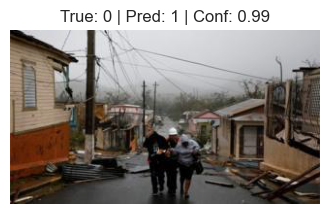

Tweet Text: (Hurricane Maria: Whole of Puerto Rico without power) - Xania News - https://t.co/GCxg69B7rp #XaniaNews https://t.co/HpxqtbeQGf
--------------------------------------------------


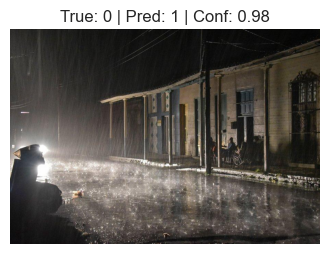

Tweet Text: RT @NinoskaPerezC: #Cuba #Irma if a picture is worth a thousand words this one needs only one: desolation https://t.co/e9uKSW5D0Q
--------------------------------------------------


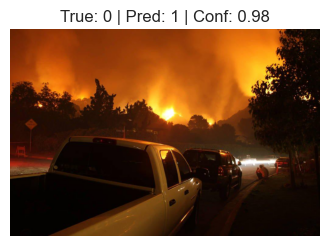

Tweet Text: ICYMI: Why California Wildfires Are Infernos In October https://t.co/sHsjtm3zxD https://t.co/N2yXSpw75i
--------------------------------------------------


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Get probabilities
probs = clf.predict_proba(X_test)
confidence = np.max(probs, axis=1)

# 2. Find errors
errors_mask = y_pred != y_test
error_indices = np.where(errors_mask)[0]

# 3. Sort errors by confidence (Most confident errors are most interesting)
# We want to see cases where the model said "100% Informative" but it was actually "Not Informative"
sorted_errors = error_indices[np.argsort(confidence[error_indices])[::-1]]

print(f"Found {len(sorted_errors)} errors. Showing top 3 worst failures...")

# 4. Display Logic (Requires reloading test_df with images if you cleared memory)
for idx in sorted_errors[:3]:
    row = test_df.iloc[idx]
    conf = confidence[idx]
    pred_label = y_pred[idx]
    true_label = y_test[idx]
    
    img_path = os.path.join(".", row['image'])
    
    try:
        img = Image.open(img_path)
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.title(f"True: {true_label} | Pred: {pred_label} | Conf: {conf:.2f}")
        plt.axis('off')
        plt.show()
        print(f"Tweet Text: {row['tweet_text']}")
        print("-" * 50)
    except:
        pass